In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import zipfile

# Формируем данные

In [2]:
# !kaggle datasets download -d kliuiev/ph2databaseaddi

In [2]:
# with zipfile.ZipFile("ph2databaseaddi.zip") as file:
#     file.extractall()

# os.remove("ph2databaseaddi.zip")
dir = "PH2Dataset/PH2 Dataset images/"
X_segnet = []
y_segnet = []
X_unet = []
y_unet = []
for ind, name in enumerate(sorted(list(os.walk(dir))[0][1])):
    for img in list(os.walk(f"PH2Dataset/PH2 Dataset images/{name}"))[0][1]:
        if img.split("_")[-1] == "Image":
            X_segnet.append(imread(f"{dir}/{name}/{img}/{img.split("_")[0]}.bmp"))
            X_unet.append(imread(f"{dir}/{name}/{img}/{img.split("_")[0]}.bmp"))
        elif img.split("_")[-1] == "lesion":
            y_segnet.append(imread(f"{dir}/{name}/{img}/{img.split("_")[0]}_lesion.bmp"))
            y_unet.append(imread(f"{dir}/{name}/{img}/{img.split("_")[0]}_lesion.bmp"))

In [3]:
len(X_segnet), len(y_unet)

(200, 200)

In [4]:
ind = random.choice(range(len(X_segnet)))
X_segnet[ind].shape, y_segnet[ind].shape

((576, 767, 3), (576, 767))

In [5]:
trans_segnet = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])
trans_unet_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96, 96))
])
trans_unet_target = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96, 96))
])
X_segnet = [trans_segnet(i) for i in X_segnet]
y_segnet = [trans_segnet(i).type(torch.float32) for i in y_segnet]

X_unet = [trans_unet_data(i) for i in X_unet]
y_unet = [trans_unet_target(i).type(torch.float32) for i in y_unet]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11561241..1.0000002].


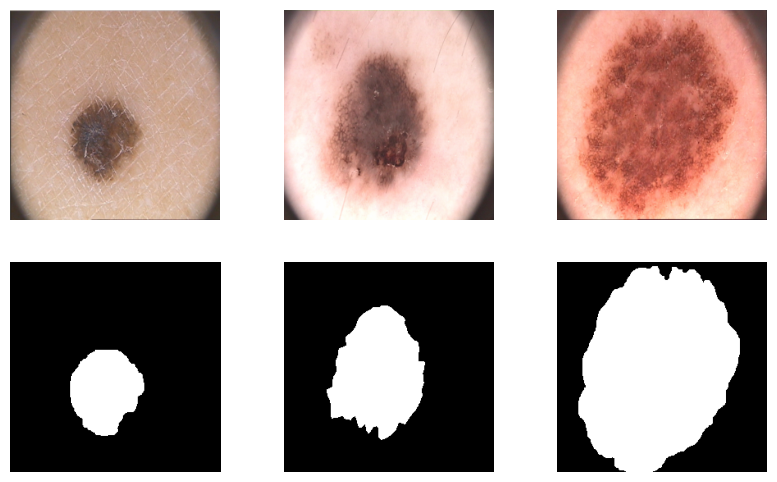

In [6]:
inds = random.sample(range(len(X_segnet)), 3)
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.ravel()

for i, ind in enumerate(inds):
    ax[i].imshow(X_segnet[ind].permute(1, 2, 0))
    ax[i].axis(False)
    ax[i + 3].imshow(y_segnet[ind].permute(1, 2, 0), cmap="gray")
    ax[i + 3].axis(False)
plt.show()

In [7]:
train_ds_segnet, test_ds_segnet = train_test_split(list(iter(zip(X_segnet, y_segnet))), test_size=0.2, shuffle=True)
train_ds_unet, test_ds_unet = train_test_split(list(iter(zip(X_unet, y_unet))), test_size=0.2, shuffle=True)

In [8]:
len(train_ds_segnet), len(test_ds_segnet)

(160, 40)

In [9]:
BATCH_SIZE = 4 # видеокарта больше не обрабатывает((
NUM_WORKERS = os.cpu_count()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
train_dataloader_segnet = DataLoader(train_ds_segnet,
                                     shuffle=True,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS)
test_dataloader_segnet = DataLoader(test_ds_segnet,
                                    shuffle=True,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)
train_dataloader_unet = DataLoader(train_ds_unet,
                                   shuffle=True,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS)
test_dataloader_unet = DataLoader(test_ds_unet,
                                  shuffle=True,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS)

# SegNet

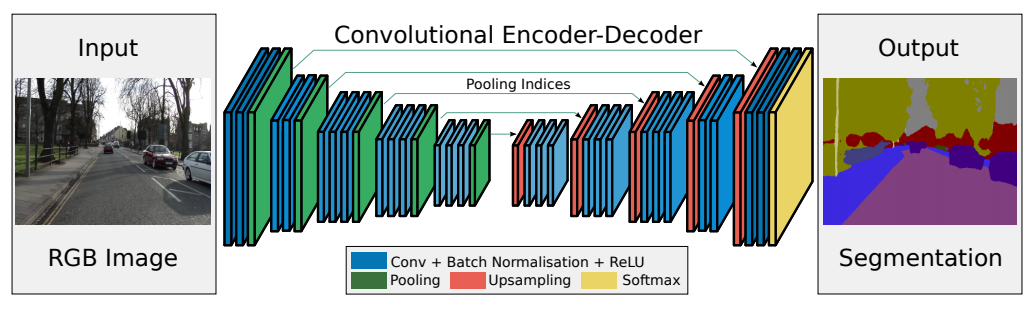

[SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561) - ссылка на статью

<img src="https://miro.medium.com/v2/resize:fit:1400/1*NNifzsJ7tD2kAfBXt3AzEg.png" width="500" height="300">

Первые 13 сверточных слоя SegNet идентичны первым 13 сверточным слоям VGG16

In [10]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode1 = nn.Sequential( # (3, 256, 256) -> (64, 128, 128)
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.encode2 = nn.Sequential(# (64, 128, 128) -> (128, 64, 64)
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.encode3 = nn.Sequential(# (128, 64, 64) -> (256, 32, 32)
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.encode4 = nn.Sequential(# (256, 32, 32) -> (512, 16, 16)
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.bottleneck = nn.Sequential(# (512, 16, 16) -> (512, 8, 8) -> (512, 16, 16)
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.deconv1 = nn.Sequential(# (512, 16, 16) -> (256, 32, 32)
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.deconv2 = nn.Sequential(# (256, 32, 32) -> (128, 64, 64)
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.deconv3 = nn.Sequential(# (128, 64, 64) -> (64, 128, 128)
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.deconv4 = nn.Sequential(# (64, 128, 128) -> (1, 256, 256)
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, 1, 1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        #encoding

        e1 = self.encode1(x)
        # print(e1.shape)
        e2 = self.encode2(e1)
        # print(e2.shape)
        e3 = self.encode3(e2)
        # print(e3.shape)
        e4 = self.encode4(e3)
        # print(e4.shape)

        #bottleneck

        bottle = self.bottleneck(e4)
        # print(bottle.shape)

        #decoding
        
        d1 = self.deconv1(bottle)
        # print(d1.shape)
        d2 = self.deconv2(d1)
        # print(d2.shape)
        d3 = self.deconv3(d2)
        # print(d3.shape)
        d4 = self.deconv4(d3)
        # print(d4.shape)

        return d4
    
segnet_model = SegNet().to(DEVICE)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=segnet_model.parameters(), lr=0.001)

In [11]:
test_pred = segnet_model(train_ds_segnet[1][0].unsqueeze(0).to(DEVICE))
test_pred.shape

torch.Size([1, 1, 256, 256])

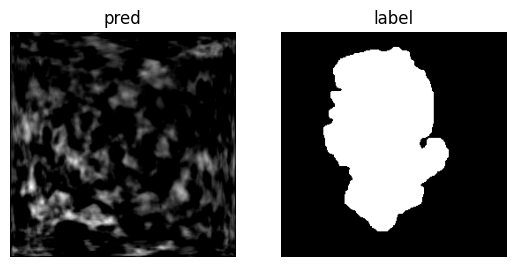

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(test_pred.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("pred")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(train_ds_segnet[1][1].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("label")
plt.axis(False)
plt.show()

Будем использовать следующую метрику:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [10]:
def IoU(pred, target, threshold=0.5):
    
    pred = (pred > threshold).float()
    
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    
    iou_value = intersection / union if union != 0 else torch.tensor(0.0)
    
    return iou_value.item()

In [14]:
IoU(test_pred, train_ds_segnet[0][1].unsqueeze(0).to(DEVICE))

0.05393332615494728

In [11]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    metric_fn,
    device,
    epochs,
    use_amp,
    scaler,
    scheduler
):
    results = {'train_loss': [], 'train_met': [], 'test_loss': [], 'test_met': []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_met = 0, 0
        test_loss, test_met = 0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            model.train()
            with torch.autocast(device_type=device, enabled=use_amp):
                y_pred = model(X) 
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            train_loss += loss
            train_met += met
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            with torch.inference_mode():
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            test_loss += loss
            test_met += met
        scheduler.step()
        print(f'EPOCH: {epoch}')
        print(f'train: metric - {train_met / len(train_dataloader)}% loss - {train_loss / len(train_dataloader)}')
        print(f'test: metric - {test_met / len(test_dataloader)}% loss - {test_loss / len(test_dataloader)}')
        results["train_loss"].append(train_loss / len(train_dataloader))
        results["train_met"].append(train_met / len(train_dataloader))
        results["test_loss"].append(test_loss / len(test_dataloader)) 
        results["test_met"].append(test_met / len(test_dataloader)) 
        print()
    return results

In [18]:
segnet_res = train(model=segnet_model,
                  train_dataloader=train_dataloader_segnet,
                  test_dataloader=test_dataloader_segnet,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  metric_fn=IoU,
                  scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 13, 0.1),
                  use_amp=True,
                  device=DEVICE,
                  scaler=torch.amp.GradScaler(),
                  epochs=30)

  3%|▎         | 1/30 [00:07<03:37,  7.48s/it]

EPOCH: 0
train: metric - 0.4015935558592901% loss - 0.650583028793335
test: metric - 0.4353217244148254% loss - 0.7216436266899109



  7%|▋         | 2/30 [00:14<03:26,  7.36s/it]

EPOCH: 1
train: metric - 0.481078515201807% loss - 0.6239330172538757
test: metric - 0.4188429780304432% loss - 0.6115139722824097



 10%|█         | 3/30 [00:22<03:18,  7.36s/it]

EPOCH: 2
train: metric - 0.5700553685426712% loss - 0.6079288721084595
test: metric - 0.6370937705039978% loss - 0.6542485356330872



 13%|█▎        | 4/30 [00:29<03:10,  7.32s/it]

EPOCH: 3
train: metric - 0.6194013431668282% loss - 0.5960963368415833
test: metric - 0.5999595940113067% loss - 0.5789991021156311



 17%|█▋        | 5/30 [00:36<03:04,  7.39s/it]

EPOCH: 4
train: metric - 0.6504078045487404% loss - 0.5940947532653809
test: metric - 0.6632369160652161% loss - 0.5772523283958435



 20%|██        | 6/30 [00:44<02:58,  7.44s/it]

EPOCH: 5
train: metric - 0.6477878287434577% loss - 0.5952213406562805
test: metric - 0.6892498075962067% loss - 0.563952624797821



 23%|██▎       | 7/30 [00:51<02:52,  7.48s/it]

EPOCH: 6
train: metric - 0.6602275744080544% loss - 0.591139018535614
test: metric - 0.5743882358074188% loss - 0.5786723494529724



 27%|██▋       | 8/30 [00:59<02:46,  7.55s/it]

EPOCH: 7
train: metric - 0.6627591565251351% loss - 0.587932825088501
test: metric - 0.7234081745147705% loss - 0.5743997097015381



 30%|███       | 9/30 [01:07<02:39,  7.58s/it]

EPOCH: 8
train: metric - 0.6888325020670891% loss - 0.58218914270401
test: metric - 0.6822041869163513% loss - 0.7241608500480652



 33%|███▎      | 10/30 [01:14<02:30,  7.55s/it]

EPOCH: 9
train: metric - 0.6482904732227326% loss - 0.5899879932403564
test: metric - 0.6413067698478698% loss - 0.5653713941574097



 37%|███▋      | 11/30 [01:22<02:23,  7.55s/it]

EPOCH: 10
train: metric - 0.6738304577767849% loss - 0.581460177898407
test: metric - 0.5439630746841431% loss - 0.6213385462760925



 40%|████      | 12/30 [01:30<02:16,  7.59s/it]

EPOCH: 11
train: metric - 0.6593187861144543% loss - 0.5894781351089478
test: metric - 0.6500374346971511% loss - 0.5730082988739014



 43%|████▎     | 13/30 [01:37<02:09,  7.64s/it]

EPOCH: 12
train: metric - 0.712942948937416% loss - 0.5743410587310791
test: metric - 0.6452894061803818% loss - 0.5679511427879333



 47%|████▋     | 14/30 [01:45<02:01,  7.62s/it]

EPOCH: 13
train: metric - 0.7259597703814507% loss - 0.5689640641212463
test: metric - 0.6513144999742508% loss - 0.5692281126976013



 50%|█████     | 15/30 [01:52<01:53,  7.57s/it]

EPOCH: 14
train: metric - 0.7506588354706765% loss - 0.5654330253601074
test: metric - 0.7328747749328614% loss - 0.5523629188537598



 53%|█████▎    | 16/30 [02:00<01:45,  7.56s/it]

EPOCH: 15
train: metric - 0.742662887275219% loss - 0.5661775469779968
test: metric - 0.6819080352783203% loss - 0.565227210521698



 57%|█████▋    | 17/30 [02:07<01:37,  7.52s/it]

EPOCH: 16
train: metric - 0.7417039111256599% loss - 0.56621915102005
test: metric - 0.6842544734477997% loss - 0.5638616681098938



 60%|██████    | 18/30 [02:15<01:31,  7.59s/it]

EPOCH: 17
train: metric - 0.73003441542387% loss - 0.5702258944511414
test: metric - 0.7124739646911621% loss - 0.5599163770675659



 63%|██████▎   | 19/30 [02:23<01:24,  7.66s/it]

EPOCH: 18
train: metric - 0.7658360868692398% loss - 0.5608949065208435
test: metric - 0.6765607714653015% loss - 0.5645127892494202



 67%|██████▋   | 20/30 [02:31<01:17,  7.78s/it]

EPOCH: 19
train: metric - 0.766368155926466% loss - 0.5639358758926392
test: metric - 0.7268795609474182% loss - 0.559550940990448



 70%|███████   | 21/30 [02:38<01:09,  7.71s/it]

EPOCH: 20
train: metric - 0.7706823989748954% loss - 0.559659481048584
test: metric - 0.717865777015686% loss - 0.5549950003623962



 73%|███████▎  | 22/30 [02:46<01:01,  7.63s/it]

EPOCH: 21
train: metric - 0.7548474878072738% loss - 0.5622385144233704
test: metric - 0.7297193586826325% loss - 0.555170476436615



 77%|███████▋  | 23/30 [02:53<00:53,  7.60s/it]

EPOCH: 22
train: metric - 0.7887429431080818% loss - 0.5558355450630188
test: metric - 0.7250834941864014% loss - 0.5588847398757935



 80%|████████  | 24/30 [03:01<00:45,  7.61s/it]

EPOCH: 23
train: metric - 0.771172060072422% loss - 0.5620493292808533
test: metric - 0.6964111745357513% loss - 0.5535901188850403



 83%|████████▎ | 25/30 [03:09<00:37,  7.56s/it]

EPOCH: 24
train: metric - 0.7422277979552746% loss - 0.5666877627372742
test: metric - 0.7781566679477692% loss - 0.5451561212539673



 87%|████████▋ | 26/30 [03:16<00:30,  7.57s/it]

EPOCH: 25
train: metric - 0.7494261279702187% loss - 0.5637585520744324
test: metric - 0.670927494764328% loss - 0.5705413222312927



 90%|█████████ | 27/30 [03:24<00:22,  7.64s/it]

EPOCH: 26
train: metric - 0.7826924011111259% loss - 0.5560600161552429
test: metric - 0.7333084583282471% loss - 0.5556753873825073



 93%|█████████▎| 28/30 [03:32<00:15,  7.69s/it]

EPOCH: 27
train: metric - 0.789838869869709% loss - 0.5544312596321106
test: metric - 0.7312170088291168% loss - 0.5569154620170593



 97%|█████████▋| 29/30 [03:40<00:07,  7.74s/it]

EPOCH: 28
train: metric - 0.7911802560091019% loss - 0.5560667514801025
test: metric - 0.7279567658901215% loss - 0.5531904101371765



100%|██████████| 30/30 [03:47<00:00,  7.60s/it]

EPOCH: 29
train: metric - 0.7751080632209778% loss - 0.560606837272644
test: metric - 0.7365062534809113% loss - 0.5560041069984436



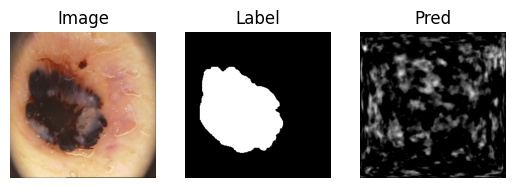

IoU - 0.20444518327713013


In [17]:
ind = random.choice(range(len(test_ds_segnet)))
test_pred = segnet_model(test_ds_segnet[ind][0].unsqueeze(0).to(DEVICE))

plt.subplot(1, 3, 1)
plt.imshow(test_ds_segnet[ind][0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Image")
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(test_ds_segnet[ind][1].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Label")
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(test_pred.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Pred")
plt.axis(False)

plt.show()
print(f"IoU - {IoU(test_pred, test_ds_segnet[ind][1].unsqueeze(0).to(DEVICE))}")

# U-Net

![Снимок экрана от 2024-10-02 22-19-43.png](<attachment:Снимок экрана от 2024-10-02 22-19-43.png>)
[U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597) - ссылка на статью
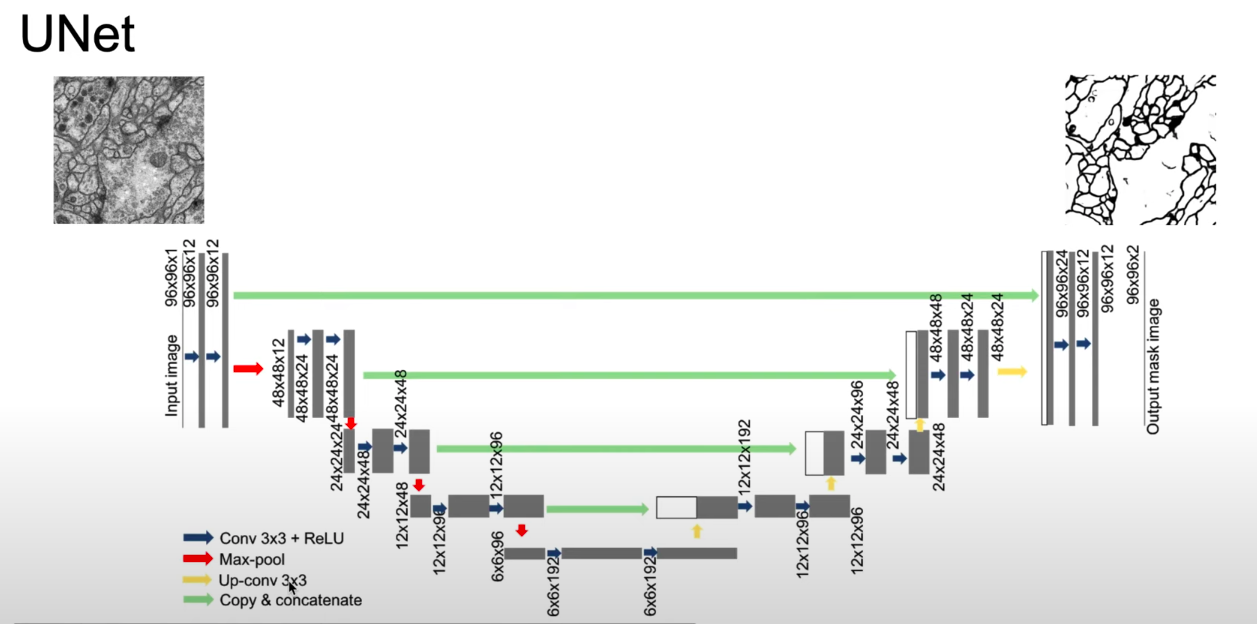

In [85]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.encode1 = nn.Sequential( # (3, 96, 96) -> (12, 48, 48) (здесь и ниже + пулинг)
            nn.Conv2d(3, 12, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.ReLU()
        )

        self.encode2 = nn.Sequential( # (12, 48, 48) -> (128, 140, 140)
            nn.Conv2d(12, 24, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 1, 1),
            nn.ReLU()
        )

        self.encode3 = nn.Sequential( # (128, 140, 140) -> (256, 68, 68)
            nn.Conv2d(24, 48, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, 1, 1),
            nn.ReLU()
        )

        self.encode4 = nn.Sequential( # (256, 68, 68) -> (512, 32, 32)
            nn.Conv2d(48, 96, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.ReLU()
        )

        self.bottleneck = nn.Sequential( # (512, 32, 32) -> (1024, 28, 28) -> (1024, 56, 56)
            nn.Conv2d(96, 192, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(12),
            nn.Conv2d(192, 96, 3, 1, 1)
        )
        self.avgpool1 = nn.AdaptiveAvgPool2d((56, 56))
        self.decode1 = nn.Sequential( # (1024, 56, 56) -> (256, 104, 104)
            nn.Conv2d(192, 96, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(24),
            nn.Conv2d(96, 48, 3, 1, 1)
        )
        self.avgpool2 = nn.AdaptiveAvgPool2d((104, 104))
        self.decode2 = nn.Sequential( # (512, 104, 104) -> (128, 200, 200)
            nn.Conv2d(96, 48, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(48),
            nn.Conv2d(48, 24, 3, 1, 1)
        )
        self.avgpool3 = nn.AdaptiveAvgPool2d((200, 200))
        self.decode3 = nn.Sequential( # (256, 200, 200) -> (64, 392, 392)
            nn.Conv2d(48, 24, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(96),
            nn.Conv2d(24, 12, 3, 1, 1)
        )
        self.avgpool4 = nn.AdaptiveAvgPool2d((392, 392))
        self.decode4 = nn.Sequential( # (128, 392, 392) -> (1, 388, 388)
            nn.Conv2d(24, 12, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.ReLU(),
            # nn.Upsample(388),
            nn.Conv2d(12, 1, 3, 1, 1)

        )

    def forward(self, x):
        e1 = self.encode1(x)
        # print(e1.shape)
        e2 = self.encode2(self.pool(e1))
        # print(e2.shape)
        e3 = self.encode3(self.pool(e2))
        # print(e3.shape)
        e4 = self.encode4(self.pool(e3))
        # print(self.pool(e4).shape)

        #bottleneck

        bottle = self.bottleneck(e4)
        # print(bottle.shape)

        #decoding
        
        d1 = self.decode1(torch.cat((bottle, e4), 1))
        # print(d1.shape)
        d2 = self.decode2(torch.cat((d1, e3), 1))
        # print(d2.shape)
        d3 = self.decode3(torch.cat((d2, e2), 1))
        # print(d3.shape)
        d4 = self.decode4(torch.cat((d3, e1), 1))
        # print(d4.shape)
        return d4
    
unet_model = UNet().to(DEVICE)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=unet_model.parameters(), lr=0.001)

In [86]:
test_pred = unet_model(train_ds_unet[1][0].unsqueeze(0).to(DEVICE))
test_pred.shape

torch.Size([1, 1, 96, 96])

In [87]:
torch.cuda.empty_cache()

In [88]:
unet_res = train(model=unet_model,
                train_dataloader=train_dataloader_unet,
                test_dataloader=test_dataloader_unet,
                optimizer=optimizer,
                loss_fn=loss_fn,
                metric_fn=IoU,
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 13, 0.1),
                use_amp=True,
                device=DEVICE,
                scaler=torch.amp.GradScaler(),
                epochs=30)

  3%|▎         | 1/30 [00:01<00:40,  1.40s/it]

EPOCH: 0
train: metric - 0.0% loss - 0.6420928239822388
test: metric - 0.0% loss - 0.5988060235977173



  7%|▋         | 2/30 [00:02<00:37,  1.35s/it]

EPOCH: 1
train: metric - 0.0% loss - 0.5945937633514404
test: metric - 0.0% loss - 0.526232898235321



 10%|█         | 3/30 [00:03<00:31,  1.15s/it]

EPOCH: 2
train: metric - 0.0% loss - 0.5459012389183044
test: metric - 0.0% loss - 0.4746003746986389



 13%|█▎        | 4/30 [00:04<00:27,  1.05s/it]

EPOCH: 3
train: metric - 0.07583149058627896% loss - 0.499296098947525
test: metric - 0.7253950238227844% loss - 0.2687905728816986



 17%|█▋        | 5/30 [00:05<00:24,  1.00it/s]

EPOCH: 4
train: metric - 0.10909238245003508% loss - 0.7156131863594055
test: metric - 0.14840459479019047% loss - 0.3965894281864166



 20%|██        | 6/30 [00:06<00:23,  1.03it/s]

EPOCH: 5
train: metric - 0.49218495599925516% loss - 0.4354841709136963
test: metric - 0.6606344610452652% loss - 0.4270350933074951



 23%|██▎       | 7/30 [00:07<00:21,  1.06it/s]

EPOCH: 6
train: metric - 0.5388671394437552% loss - 0.4228997826576233
test: metric - 0.5563615635037422% loss - 0.32378503680229187



 27%|██▋       | 8/30 [00:08<00:20,  1.07it/s]

EPOCH: 7
train: metric - 0.5119135320186615% loss - 0.42635783553123474
test: metric - 0.6493710815906525% loss - 0.30631572008132935



 30%|███       | 9/30 [00:09<00:19,  1.07it/s]

EPOCH: 8
train: metric - 0.5861135460436344% loss - 0.3646222651004791
test: metric - 0.7088435620069504% loss - 0.40994200110435486



 33%|███▎      | 10/30 [00:10<00:18,  1.06it/s]

EPOCH: 9
train: metric - 0.5796148214489222% loss - 0.3963277041912079
test: metric - 0.6763746976852417% loss - 0.2998952567577362



 37%|███▋      | 11/30 [00:10<00:17,  1.06it/s]

EPOCH: 10
train: metric - 0.6320227399468422% loss - 0.3420279324054718
test: metric - 0.73075350522995% loss - 0.24007605016231537



 40%|████      | 12/30 [00:11<00:17,  1.06it/s]

EPOCH: 11
train: metric - 0.6328821696341038% loss - 0.32742998003959656
test: metric - 0.7051595568656921% loss - 0.2320956438779831



 43%|████▎     | 13/30 [00:12<00:16,  1.06it/s]

EPOCH: 12
train: metric - 0.6924666576087475% loss - 0.28172367811203003
test: metric - 0.7749356627464294% loss - 0.17506007850170135



 47%|████▋     | 14/30 [00:13<00:15,  1.05it/s]

EPOCH: 13
train: metric - 0.7401812613010407% loss - 0.23467543721199036
test: metric - 0.7698924124240876% loss - 0.17264479398727417



 50%|█████     | 15/30 [00:14<00:14,  1.06it/s]

EPOCH: 14
train: metric - 0.7448857456445694% loss - 0.2224435806274414
test: metric - 0.7927367866039277% loss - 0.17423449456691742



 53%|█████▎    | 16/30 [00:15<00:13,  1.07it/s]

EPOCH: 15
train: metric - 0.7614336162805557% loss - 0.21694926917552948
test: metric - 0.7999370157718658% loss - 0.16661594808101654



 57%|█████▋    | 17/30 [00:16<00:12,  1.07it/s]

EPOCH: 16
train: metric - 0.7736262455582619% loss - 0.20782451331615448
test: metric - 0.8127197325229645% loss - 0.1567486673593521



 60%|██████    | 18/30 [00:17<00:11,  1.05it/s]

EPOCH: 17
train: metric - 0.7777848318219185% loss - 0.19534806907176971
test: metric - 0.8248535454273224% loss - 0.15096934139728546



 63%|██████▎   | 19/30 [00:18<00:10,  1.07it/s]

EPOCH: 18
train: metric - 0.7871836066246033% loss - 0.18612639605998993
test: metric - 0.8334828197956086% loss - 0.14704175293445587



 67%|██████▋   | 20/30 [00:19<00:09,  1.04it/s]

EPOCH: 19
train: metric - 0.7871908470988274% loss - 0.19118677079677582
test: metric - 0.8357130825519562% loss - 0.14537940919399261



 70%|███████   | 21/30 [00:20<00:08,  1.03it/s]

EPOCH: 20
train: metric - 0.8092303857207298% loss - 0.1705295294523239
test: metric - 0.8537925064563752% loss - 0.14425164461135864



 73%|███████▎  | 22/30 [00:21<00:07,  1.06it/s]

EPOCH: 21
train: metric - 0.818809150159359% loss - 0.16451233625411987
test: metric - 0.8572468101978302% loss - 0.1501443237066269



 77%|███████▋  | 23/30 [00:22<00:06,  1.06it/s]

EPOCH: 22
train: metric - 0.8136370331048965% loss - 0.1662055253982544
test: metric - 0.854410982131958% loss - 0.1475977897644043



 80%|████████  | 24/30 [00:23<00:05,  1.07it/s]

EPOCH: 23
train: metric - 0.8244887083768845% loss - 0.153485968708992
test: metric - 0.8562678456306457% loss - 0.13288664817810059



 83%|████████▎ | 25/30 [00:24<00:04,  1.08it/s]

EPOCH: 24
train: metric - 0.8355367884039879% loss - 0.14596183598041534
test: metric - 0.8614335179328918% loss - 0.1295476257801056



 87%|████████▋ | 26/30 [00:25<00:03,  1.09it/s]

EPOCH: 25
train: metric - 0.8342899590730667% loss - 0.1487160474061966
test: metric - 0.8323406755924225% loss - 0.14103810489177704



 90%|█████████ | 27/30 [00:26<00:02,  1.05it/s]

EPOCH: 26
train: metric - 0.8352771416306496% loss - 0.1406492441892624
test: metric - 0.8554844856262207% loss - 0.12784723937511444



 93%|█████████▎| 28/30 [00:27<00:02,  1.01s/it]

EPOCH: 27
train: metric - 0.8418912872672081% loss - 0.13482673466205597
test: metric - 0.858769291639328% loss - 0.12899033725261688



 97%|█████████▋| 29/30 [00:28<00:01,  1.00s/it]

EPOCH: 28
train: metric - 0.8475467011332511% loss - 0.13346432149410248
test: metric - 0.8642621815204621% loss - 0.12920977175235748



100%|██████████| 30/30 [00:29<00:00,  1.03it/s]

EPOCH: 29
train: metric - 0.8460175573825837% loss - 0.13308385014533997
test: metric - 0.8585451781749726% loss - 0.13032440841197968



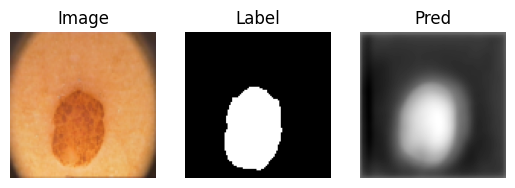

IoU - 0.841375470161438


In [108]:
ind = random.choice(range(len(test_ds_unet)))
test_pred = unet_model(test_ds_unet[ind][0].unsqueeze(0).to(DEVICE))

plt.subplot(1, 3, 1)
plt.imshow(test_ds_unet[ind][0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Image")
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(test_ds_unet[ind][1].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Label")
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(test_pred.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Pred")
plt.axis(False)

plt.show()
print(f"IoU - {IoU(test_pred, test_ds_unet[ind][1].unsqueeze(0).to(DEVICE))}")

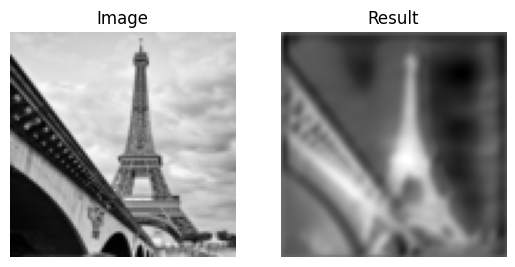

In [119]:
img_test = Image.open('1.jpg')
img_test_trans = trans_unet_data(img_test).to(DEVICE)

plt.subplot(1, 2, 1)
plt.imshow(img_test_trans.permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Image")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(unet_model(img_test_trans.unsqueeze(0)).squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
plt.title("Result")
plt.axis(False)
plt.show()